<a href="https://colab.research.google.com/github/Jayant1408/Cat-Vs-Dog-Classifier/blob/main/Cat_Vs_Dog_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   105M      0  0:00:07  0:00:07 --:--:--  112M


In [2]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls


 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [3]:
!ls PetImages

Cat  Dog


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1590 images


In [6]:
import matplotlib.pyplot as plt


In [7]:
image_size = (180,180)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


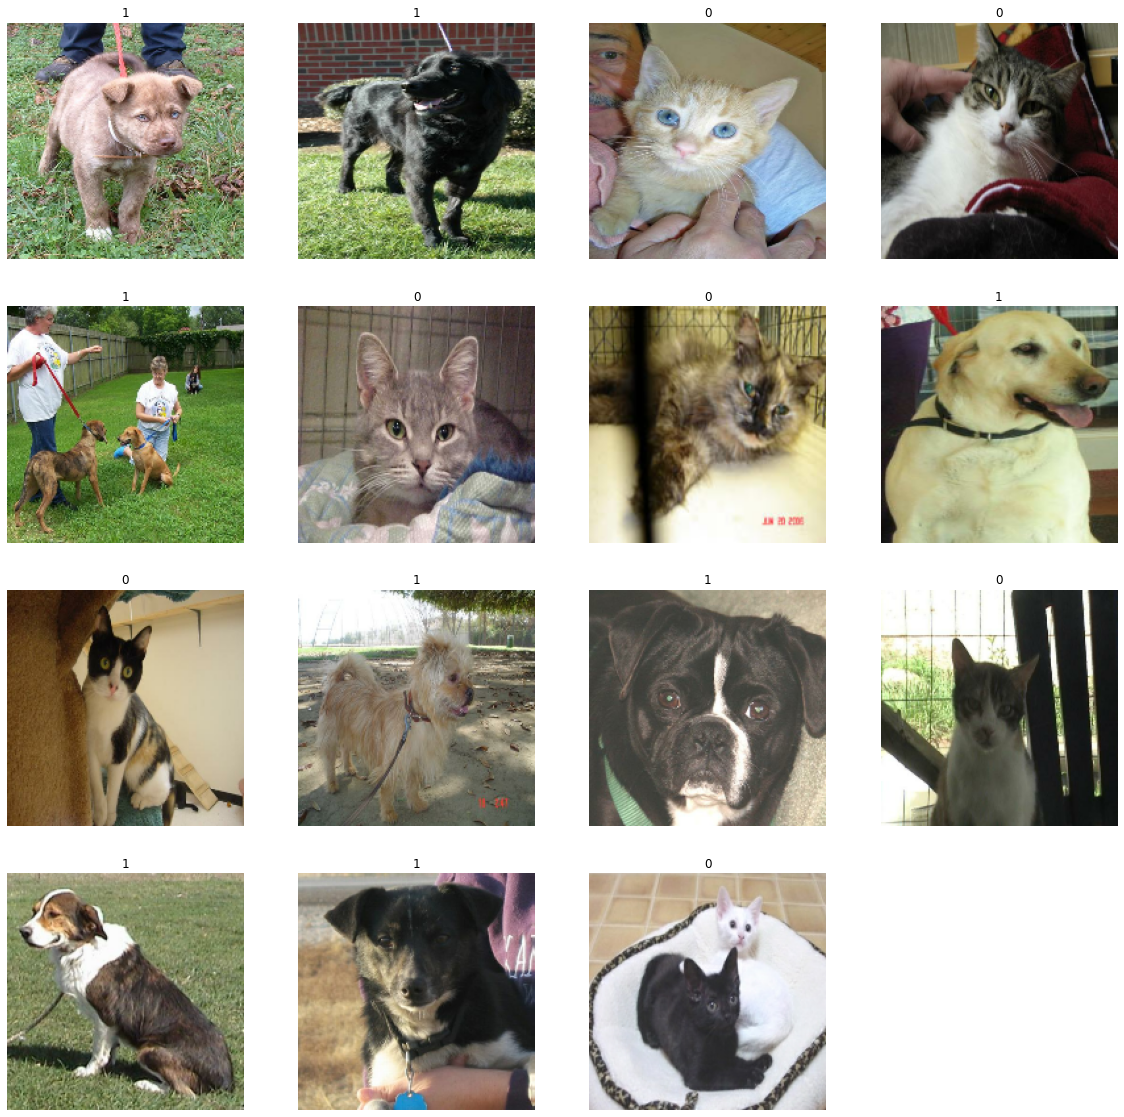

In [8]:
plt.figure(figsize=(20,20))
for images,labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [11]:
DA = keras.Sequential(
    [
     
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.1),
     
    ]
)

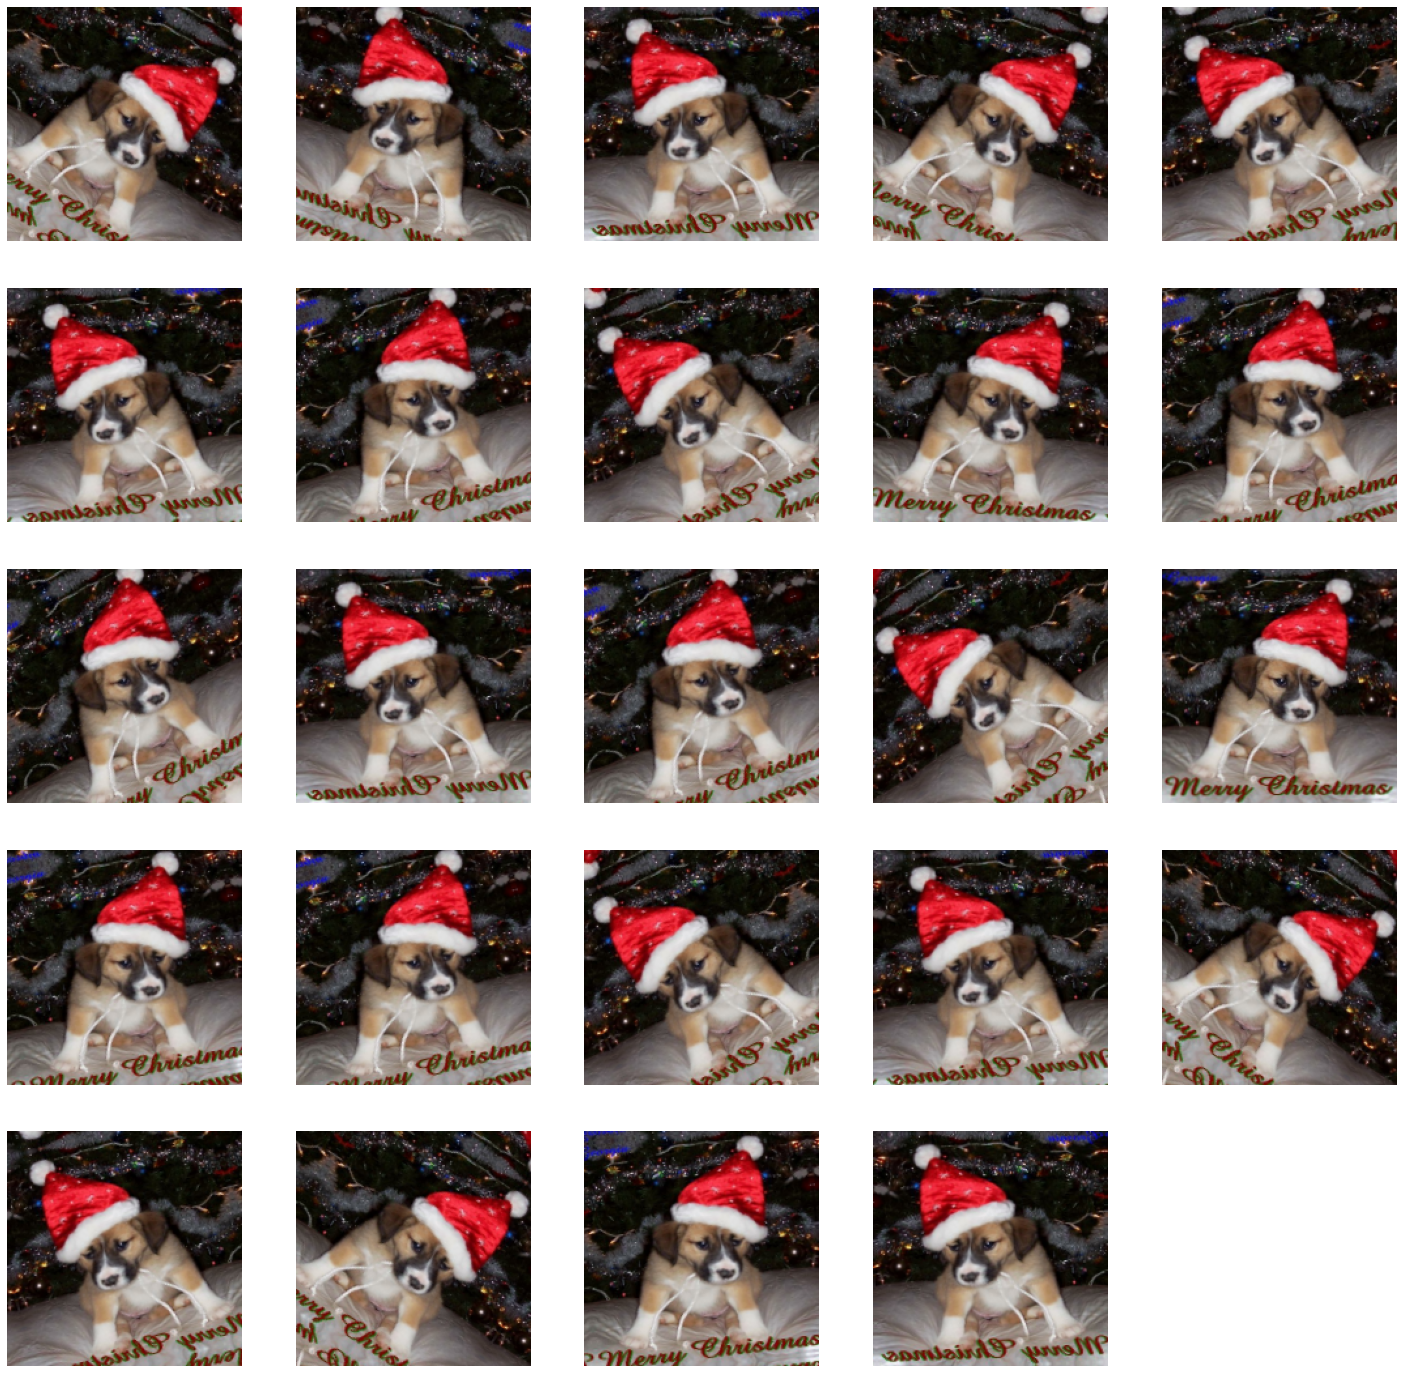

In [15]:
plt.figure(figsize=(25, 25))
for images, _ in train_ds.take(1):
    for i in range(24):
        augmented_images = DA(images)
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [18]:
train_ds = train_ds.prefetch(buffer_size=32)
valid_ds = valid_ds.prefetch(buffer_size=32)


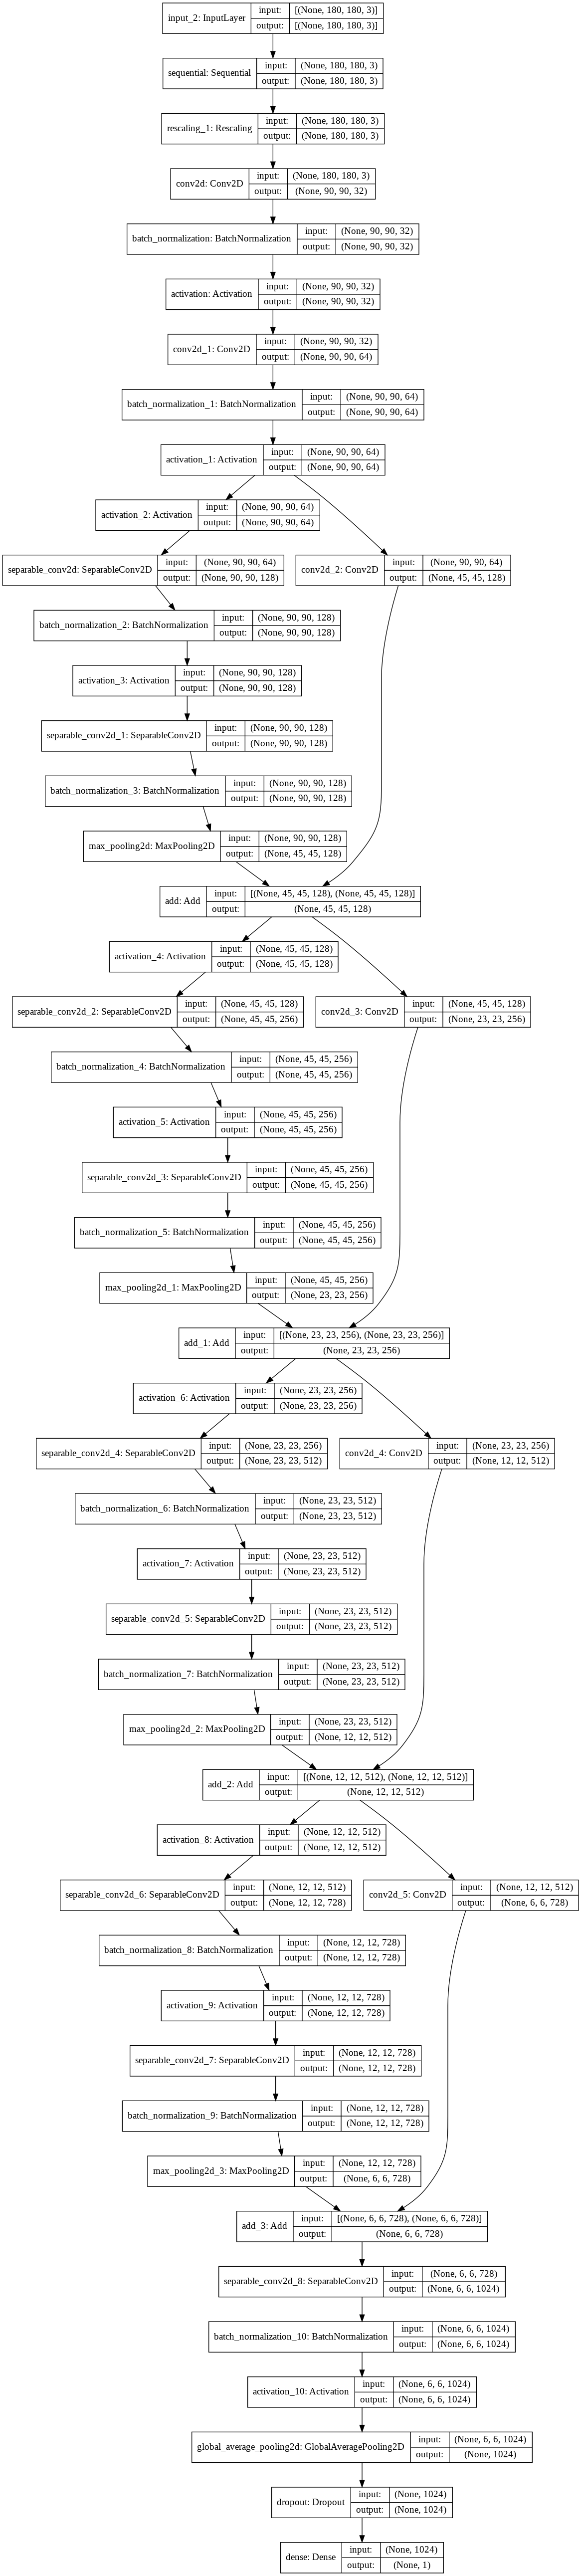

In [20]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = DA(inputs)
    x = layers.experimental.preprocessing.Rescaling(1./255)(x)

    x = DA(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [24]:
 epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds,
)


Epoch 1/10
586/586 [==============================] - 304s 513ms/step - loss: 0.4499 - accuracy: 0.7909 - val_loss: 1.0811 - val_accuracy: 0.6576
Epoch 2/10
586/586 [==============================] - 300s 512ms/step - loss: 0.3629 - accuracy: 0.8410 - val_loss: 0.3145 - val_accuracy: 0.8721
Epoch 3/10
586/586 [==============================] - 300s 512ms/step - loss: 0.3078 - accuracy: 0.8688 - val_loss: 0.4622 - val_accuracy: 0.7883
Epoch 4/10
586/586 [==============================] - 302s 514ms/step - loss: 0.2655 - accuracy: 0.8854 - val_loss: 0.3070 - val_accuracy: 0.8733
Epoch 5/10
586/586 [==============================] - 302s 514ms/step - loss: 0.2241 - accuracy: 0.9062 - val_loss: 0.1803 - val_accuracy: 0.9240
Epoch 6/10
586/586 [==============================] - 301s 512ms/step - loss: 0.2005 - accuracy: 0.9180 - val_loss: 0.2240 - val_accuracy: 0.9041
Epoch 7/10
586/586 [==============================] - 301s 513ms/step - loss: 0.1929 - accuracy: 0.9211 - val_loss: 0.1655 -

This image is 99.89 percent cat and 0.11 percent dog.


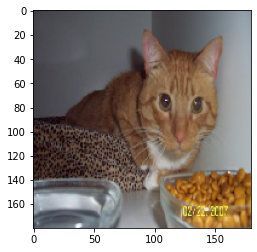

In [29]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6778.jpg", target_size=image_size
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)
